In [11]:
import pandas as pd
import numpy as np
import nltk
import pickle
import re
import emoji

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [5]:
# Download the stopwords for English language
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aktha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Set the maximum number of words to keep based on word frequency
max_words = 10000

# Set random seed for reproducibility
np.random.seed(42)

# Load the data from the CSV file
df = pd.read_csv('C:/Sentiment-Analysis-Model/datasets/datasetEN.csv')

# Drop duplicates and make a copy of the DataFrame
df = df.drop_duplicates().copy()

# Preprocess the text
def preprocess_text(text):
    # Check if text is not null
    if isinstance(text, str):
        # Remove special characters and convert to lowercase
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        # Join tokens back into a string
        text = " ".join(tokens)
    return text

# Apply preprocessing to the text column
df['text'] = df['text'].apply(preprocess_text)

# Remove rows with null values in 'text' column
df = df.dropna(subset=['text'])

# Split the data into text and labels
x = df['text'].values
y = df['sentiment'].values

# Convert the labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Get the maximum sequence length
maxlen = max(len(x) for x in x_train)
print('maxlen:', maxlen)
# Pad sequences to have the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

maxlen: 129


<Axes: >

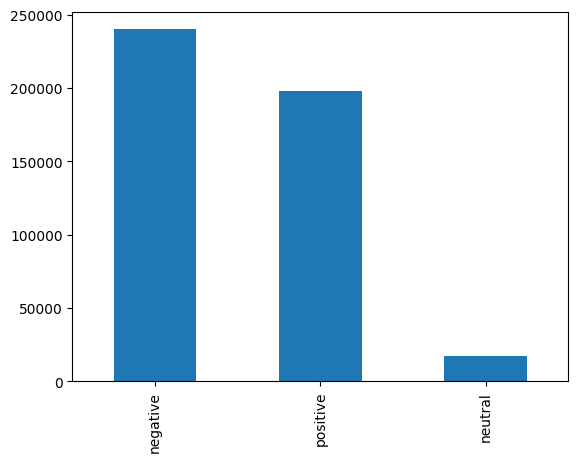

In [13]:
df['sentiment'].value_counts().plot.bar()

In [14]:
# Define the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(set(df['sentiment'])), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 129, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 125, 128)          82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [15]:
# Define callbacks
filename = 'sentiment_analysis_modelEN.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.000001)
callbacks = [checkpoint, learning_rate_reduction]

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/5
5690/5690 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9367
Epoch 1: val_loss improved from inf to 0.09992, saving model to sentiment_analysis_modelEN.h5
5690/5690 [==============================] - 255s 45ms/step - loss: 0.1491 - accuracy: 0.9367 - val_loss: 0.0999 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/5
5689/5690 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.9679
Epoch 2: val_loss improved from 0.09992 to 0.08417, saving model to sentiment_analysis_modelEN.h5
5690/5690 [==============================] - 264s 46ms/step - loss: 0.0754 - accuracy: 0.9679 - val_loss: 0.0842 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 3/5
5690/5690 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9779
Epoch 3: val_loss improved from 0.08417 to 0.07787, saving model to sentiment_analysis_modelEN.h5
5690/5690 [==============================] - 247s 43ms/step - loss: 0.0490 - accuracy: 0.9779 - val_loss: 0.0779 - val_ac

In [16]:
# Load the best model
model = load_model(filename)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict classes for test data
y_pred = model.predict(x_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
confusion_mat = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
print("Confusion Matrix:")
print(confusion_mat)

# Calculate precision, recall, and F1-score
precision = precision_score(np.argmax(y_test, axis=1), predicted_classes, average=None)
recall = recall_score(np.argmax(y_test, axis=1), predicted_classes, average=None)
f1 = f1_score(np.argmax(y_test, axis=1), predicted_classes, average=None)

# Print precision, recall, and F1-score for each class
for i, label in enumerate(set(df['sentiment'])):
    print(f"Class: {label}")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1-score:", f1[i])
    print()

Test Loss: 0.0778680145740509
Test Accuracy: 0.9685041904449463
2845/2845 [==============================] - 15s 5ms/step
Confusion Matrix:
[[47086   238   541]
 [  254  3079   203]
 [ 1374   257 37996]]
Class: neutral
Precision: 0.9665804491521944
Recall: 0.9837250600647655
F1-score: 0.9750773977779849

Class: negative
Precision: 0.8614997202014549
Recall: 0.8707579185520362
F1-score: 0.8661040787623066

Class: positive
Precision: 0.9807950438822922
Recall: 0.9588411941353118
F1-score: 0.9696938762489313



In [17]:
# Save the trained model and the tokenizer to disk
model.save('sentiment_analysis_modelEN.h5')
with open('tokenizerEN.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [13]:
# Load model and tokenizer
with open('tokenizerEN.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = load_model('sentiment_analysis_modelEN.h5')

In [66]:
new_text = 'The traffic this morning was so annoying, and I was late for work'
new_text = preprocess_text(new_text)
print('new_text:', new_text)
new_text = tokenizer.texts_to_sequences([new_text])  # Convert text to sequences of integers
new_text = pad_sequences(new_text, maxlen=maxlen)
# Make the prediction
prediction = model.predict(new_text)[0]

# Get the predicted sentiment and confidence level
sentiments = ['Negative', 'Neutral', 'Positive']
sentiment = sentiments[np.argmax(prediction)]
confidence = np.max(prediction)

# Display the result
print(f'{sentiment} ({confidence * 100:.2f}%)')

new_text: traffic morning annoying late work
1/1 [==============================] - 0s 79ms/step
Negative (98.86%)
